In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.patches import Rectangle
import cv2
from skimage import color
from skimage.io import imread
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from tqdm.auto import tqdm as tqdm_nn
import random
import requests
from requests.exceptions import ConnectionError
from requests.exceptions import ReadTimeout

In [2]:
def clip_image(url, bbox):
    image = imread(url)
    
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    
    w=x2-x1
    h=y2-y1
    
    crop_img = image[y1:y1+h, x1:x1+w]
    new_size = 224,224
    crop_img = cv2.resize(crop_img, new_size, interpolation=cv2.INTER_CUBIC)
    plt.figure()
    plt.imshow(crop_img)

In [3]:
def bbox_on_img(url, bbox):
    image = imread(url)
    plt.figure()
    plt.imshow(image)
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]
    
    w=x2-x1
    h=y2-y1
    rect = Rectangle((x1, y1), w, h, fill=False, color='r')
    plt.axes().add_patch(rect)
    plt.show()   

In [4]:
def process_celeb(name, path):
    # format is 
    # Each line represents:
    # id url left top right bottom pose detection_score curation
    # id: Integer id for an image 
    # url: The weblink for the image. 
    # [left top right bottom] the bounding box for an image. 
    # pose: frontal/profile (pose>2 signifies a frontal face while
    # pose<=2 represents left and right profile detection).
    # detection score: Score of a DPM detector.
    # curation: Whether this image was a part of final curated dataset
    
    df = pd.read_csv(path, sep=' ', names=['ID', 'URL', 'LEFT', 'TOP', 'RIGHT', 'BOTTOM', 'POSE', 'DETECTION', 'CURATION'])
    celeb_list = [name] * len(df)
    df['CELEB'] = celeb_list
    return df
        

In [5]:
def get_celeb_box(df, name, img_num):
    the_box_row = df.loc[df['CELEB']==name]
    the_box_row = the_box_row.iloc[img_num]
    return the_box_row[['LEFT', 'TOP', 'RIGHT', 'BOTTOM']].values

In [6]:
def get_celeb_url(df, name, img_num):
    the_url_row = df.loc[df['CELEB']==name].iloc[img_num]['URL']
    return the_url_row

In [7]:
def url_ok(url):
    try:
        r = requests.head(url, timeout=timeout)
        return r.status_code == 200
    except (ConnectionError, ReadTimeout)  as e:
        #print("URL connection error", url)
        return False

In [8]:
valid_face_urls_path = 'vgg_face_full_urls.csv'
face_urls_path = 'vgg_face_full.csv'

if not os.path.exists(valid_face_urls_path):  
    path = 'vgg_face_dataset/files'
    for (dirpath, dirnames, filenames) in os.walk(path):
        df = None
        for filename in tqdm(filenames):
            if filename.endswith('.txt'): 
                celeb_name = os.path.splitext(filename)[0]
                full_path = os.sep.join([dirpath, filename])
                #print("Processing: ["+celeb_name+"]: full path: ["+full_path+"]")
                if df is not None:
                    df = df.append(process_celeb(celeb_name,  full_path))
                else:
                    df = process_celeb(celeb_name, full_path)
    
    df.to_csv(face_urls_path)
    print('Num Celeb Images', str(len(df)))
else:
    # run the script vgg_valid_url.py and change n_cores to how many parallel proc you want validating the URLs
    # running this script will yield a new dataframe saved in the file that you are opening below with a new 
    # column, VALID_URL set to True if the result of requests.head(url, timeout=0.0001) is 200, else False
    df = pd.read_csv(valid_face_urls_path)    

In [9]:
num_valid_urls = str(len(df[df.VALID_URL==True]))
num_invalid_urls = str(len(df[df.VALID_URL==False]))
print('Num valid URLs', num_valid_urls)
print('Num invalid URLs', num_invalid_urls)

Num valid URLs 1252215
Num invalid URLs 1352634


In [10]:
df = df[df.VALID_URL==True]

In [11]:
print('Size new DF only valid URLs', str(len(df)))

Size new DF only valid URLs 1252215


In [12]:
celeb_names = df.CELEB.unique()
print(celeb_names)

['Hailee_Steinfeld' 'William_Powell' 'Zachary_Quinto' ...
 'Jean_Louisa_Kelly' 'Jennifer_Finnigan' 'Ashley_Jones']


Random Celeb Elon_Musk
Random Pic Num 20
[299.0 64.33 394.67 160.0]
http://media-1.web.britannica.com/eb-media/88/154388-004-F01361C0.jpg


/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


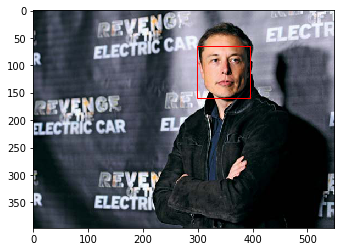

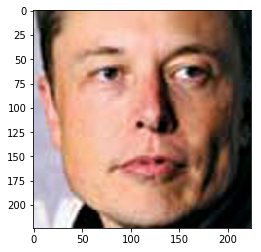

In [13]:
rand_celeb = random.randint(0, len(celeb_names))
rand_pic_num = random.randint(0, 50) # top 50 pics
celeb_name = celeb_names[rand_celeb]
c_num = rand_pic_num

print('Random Celeb', celeb_name)
print('Random Pic Num', str(c_num))

c_box =  get_celeb_box(df, celeb_name, c_num)
print(c_box)
c_url= get_celeb_url(df, celeb_name, c_num)
print(c_url)

bbox_on_img(c_url, c_box)
clip_image(c_url, c_box)

In [14]:
df.head()

,Unnamed: 0,Unnamed: 0.1,ID,URL,LEFT,TOP,RIGHT,BOTTOM,POSE,DETECTION,CURATION,CELEB,VALID_URL
0,0,0,1,http://ethnicelebs.com/wp-content/uploads/2011...,93.19,111.76,260.00,278.58,3.0,4.01,1,Hailee_Steinfeld,True
1,1,1,2,http://media3.onsugar.com/files/2012/09/38/4/1...,184.79,184.79,514.62,514.62,3.0,4.07,1,Hailee_Steinfeld,True
3,3,3,4,http://www.teenidols4you.com/blink/Actors/hail...,169.90,127.67,358.91,316.68,4.0,4.08,1,Hailee_Steinfeld,True
4,4,4,5,http://img2.timeinc.net/instyle/images/2011/aw...,78.98,156.95,311.90,389.88,4.0,3.79,1,Hailee_Steinfeld,True
5,5,5,6,http://www3.pictures.zimbio.com/gi/Hailee%252B...,73.85,147.37,294.07,367.58,3.0,4.62,1,Hailee_Steinfeld,True


In [15]:
plot_df = df.groupby('CELEB').count()[['URL']]
plot_df.head()

,URL
CELEB,
A.J._Buckley,550
A.R._Rahman,434
A_P_J_Abdul_Kalam,165
Aamir_Khan,375
Aaron_Staton,536


In [16]:
plot_df.mean()

URL    477.580092
dtype: float64

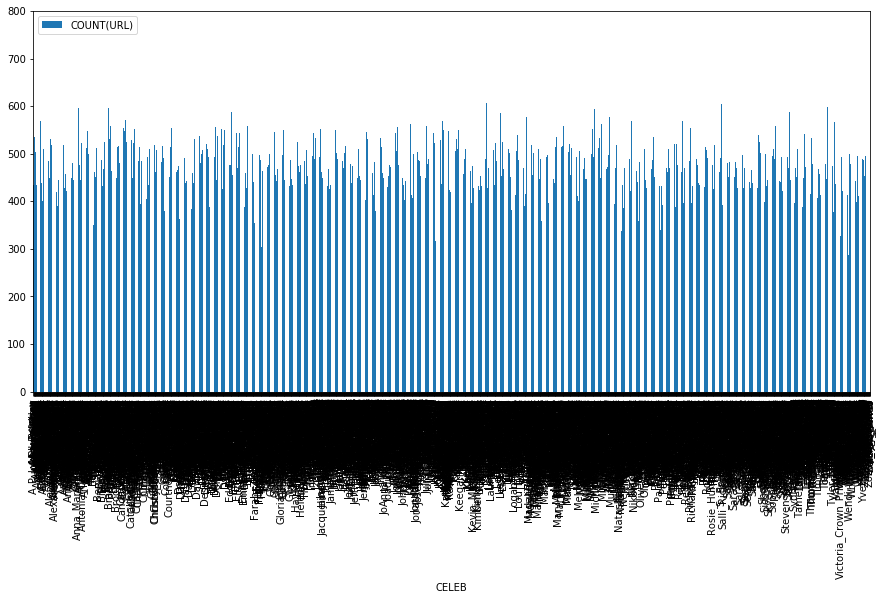

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xticklabels(df.index)
plot_df = plot_df.rename(columns={'URL':'COUNT(URL)'})
plot_df.plot.bar(ax=ax)

In [21]:
df.reset_index(inplace=True)

In [22]:
df.head()

,level_0,index,Unnamed: 0,Unnamed: 0.1,ID,URL,LEFT,TOP,RIGHT,BOTTOM,POSE,DETECTION,CURATION,CELEB,VALID_URL
0,0,0,0,0,1,http://ethnicelebs.com/wp-content/uploads/2011...,93.19,111.76,260.00,278.58,3.0,4.01,1,Hailee_Steinfeld,True
1,1,1,1,1,2,http://media3.onsugar.com/files/2012/09/38/4/1...,184.79,184.79,514.62,514.62,3.0,4.07,1,Hailee_Steinfeld,True
2,2,3,3,3,4,http://www.teenidols4you.com/blink/Actors/hail...,169.90,127.67,358.91,316.68,4.0,4.08,1,Hailee_Steinfeld,True
3,3,4,4,4,5,http://img2.timeinc.net/instyle/images/2011/aw...,78.98,156.95,311.90,389.88,4.0,3.79,1,Hailee_Steinfeld,True
4,4,5,5,5,6,http://www3.pictures.zimbio.com/gi/Hailee%252B...,73.85,147.37,294.07,367.58,3.0,4.62,1,Hailee_Steinfeld,True


In [23]:
df.index

RangeIndex(start=0, stop=1252215, step=1)